In [20]:
from sklearn.cluster import KMeans, DBSCAN
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import umap
import seaborn as sns

## Dimensionality Reduction

In [12]:
df_path = os.path.join('..','..', 'src', 'graph_benchmark', 'user_embeddings.csv')
df = pd.read_csv(df_path)
user_ids = df['user_id']
df = df.drop(columns=['id', 'user_id'])
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.212749,0.196454,0.214248,0.020394,0.302239,0.259363,-0.365282,-0.034944,-0.277754,0.373187,...,-0.490232,-0.812718,1.112215,-0.400508,-0.056237,0.221986,-0.814590,0.212915,0.116431,-0.798757
1,-0.048734,-0.112042,0.677098,-0.063632,0.876423,0.161918,-0.824396,0.413559,-0.848101,-0.702777,...,-1.667365,-0.971833,-0.372028,-0.376922,-0.355528,-0.116560,-0.274357,0.158723,-0.330767,-1.136413
2,-0.077174,-7.516248,0.563232,-1.094236,-3.449165,-3.173086,-0.704255,-1.110837,-0.562908,6.125888,...,-0.076624,2.201152,0.313209,5.158866,-1.203652,-2.529123,-1.450975,-0.141506,-5.486949,-5.231559
3,-0.128528,0.109473,-0.079922,-0.116040,-0.330592,0.717851,0.088396,0.580383,0.135043,-0.161022,...,-0.339694,-0.663881,0.341226,-0.064240,-0.050024,0.059967,-0.301545,0.428051,-0.557375,0.031803
4,-7.880645,0.443912,-3.068011,4.750346,0.429083,-4.081886,2.812023,0.971784,5.530701,-2.054908,...,6.863417,-0.627983,-7.610782,-3.648584,5.379857,-1.423053,3.728926,-2.741189,-0.216132,0.226005


In [13]:
scaler = MinMaxScaler()
features_to_scale = list(df.columns)
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.916390,0.900776,0.368506,0.243938,0.908061,0.395211,0.806105,0.121820,0.346361,0.249487,...,0.357453,0.079801,0.532717,0.514136,0.227987,0.492218,0.275911,0.590769,0.529994,0.498725
1,0.886783,0.873644,0.404618,0.235206,0.946394,0.387106,0.778087,0.158298,0.282178,0.138931,...,0.254598,0.063760,0.442074,0.515298,0.207051,0.470770,0.317431,0.586987,0.504438,0.476086
2,0.883563,0.222463,0.395734,0.128110,0.657614,0.109748,0.785419,0.034316,0.314272,0.840577,...,0.393593,0.383635,0.483921,0.788058,0.147722,0.317927,0.227002,0.566033,0.209774,0.201521
3,0.877749,0.893126,0.345555,0.229760,0.865813,0.433341,0.833790,0.171866,0.392814,0.194597,...,0.370607,0.094806,0.485632,0.530705,0.228422,0.481954,0.315341,0.605784,0.491488,0.554411
4,0.000000,0.922539,0.112420,0.735455,0.916529,0.034166,1.000000,0.203699,1.000000,0.000000,...,1.000000,0.098425,0.000000,0.354096,0.608261,0.388000,0.625102,0.384593,0.510989,0.567431


In [15]:
# Dimensionality reduction using UMAP
reducer = umap.UMAP(n_components=3, random_state=42)
embedding = reducer.fit_transform(df)
embedding[0]

/home/acaia/Analysa/Analysa/.analysa/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


array([5.7555566, 3.164502 , 4.068693 ], dtype=float32)

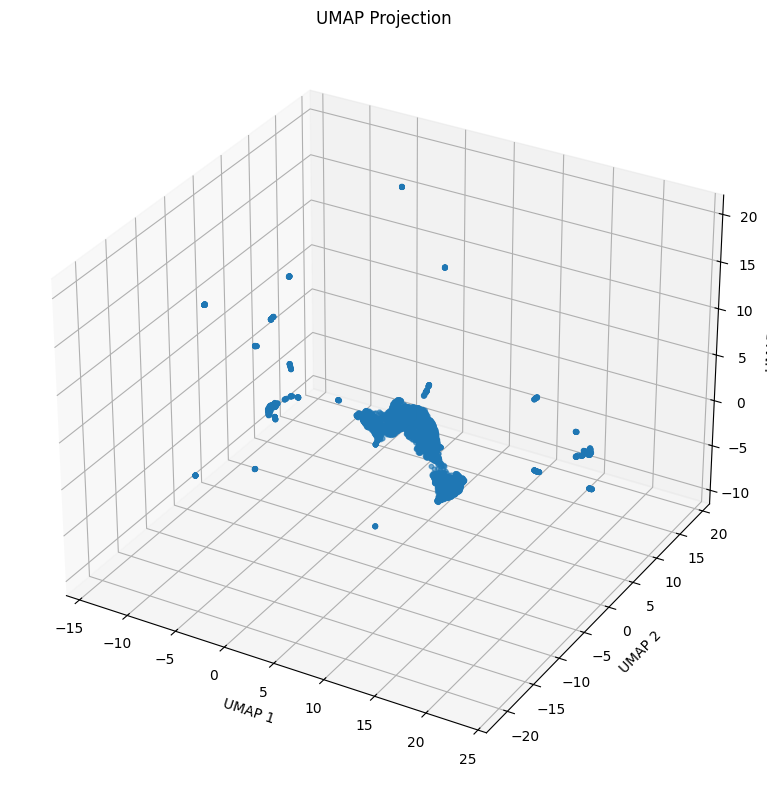

In [17]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    embedding[:,0],
    embedding[:,1],
    embedding[:,2],
    alpha=0.6,
    s=10
)

ax.set_title('UMAP Projection')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_zlabel('UMAP 3')

plt.tight_layout()
plt.show()

## Clustering

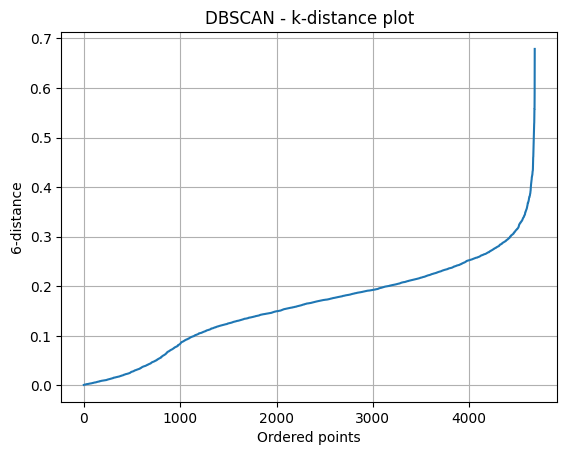

In [18]:
from sklearn.neighbors import NearestNeighbors

min_samples = 6 # Thus 2 * Latent dimension
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(embedding)
distances,_= nbrs.kneighbors(embedding)
k_distances = np.sort(distances[:,min_samples - 1])

plt.plot(k_distances)
plt.xlabel("Ordered points")
plt.ylabel(f"{min_samples}-distance")
plt.title("DBSCAN - k-distance plot")
plt.grid()
plt.show()

In [34]:
dbscan = DBSCAN(eps=0.3,min_samples=6)
cluster_predictions = dbscan.fit_predict(embedding)

n_clusters = len(set(cluster_predictions)) - (1 if -1 in cluster_predictions else 0)
n_noise = list(cluster_predictions).count(-1)

print(f"Numero di cluster trovati: {n_clusters}")
print(f"Punti etichettati come noise: {n_noise} ({n_noise / len(cluster_predictions):.2%})")


Numero di cluster trovati: 29
Punti etichettati come noise: 51 (1.09%)


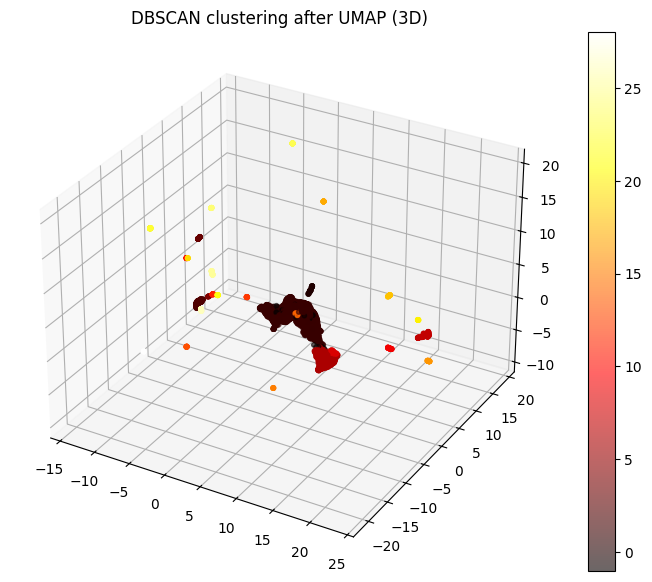

In [35]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    embedding[:, 0], embedding[:, 1], embedding[:, 2],
    c=cluster_predictions, cmap='hot', s=10, alpha=0.6
)
ax.set_title("DBSCAN clustering after UMAP (3D)")
plt.colorbar(scatter)
plt.show()